## I. Prerequisites

This tutorial assumes familiarity (but not expertise) with the following:

* ML Chain: the inputs and outputs of the ML portion of the reconstruction.
* Analysis tools: configuring basic post-processors, setting up loggers for writing CSVs. 

The following are required:
* An instance of `lartpc_mlreco3d` (v2.8.6 at time of tutorial): [Github](https://github.com/DeepLearnPhysics/lartpc_mlreco3d/tree/v2.8.6)
* An installation of `OpT0Finder`: [Github](https://github.com/drinkingkazu/OpT0Finder)
* An HDF5 data file for input: We will use a BNB nu_mu + out-of-time cosmics sample with a small number of events.
* A set of CSV output files: A set of CSVs prepared identically to this notebook, but with a larger sample. This is provided.

## II. What is flash matching (with OpT0Finder)?

### Overview
Particle interactions in LArTPCs produce signal in both the TPC (charge) and the PMTs (light). The typical interaction will be seen by the PMTs as a flash of light ocurring ~ nanoseconds after the interaction and by the TPC as a cluster of charge reaching the anode wire planes up to a millisecond later. Knowing the precise time of an interaction is a powerful background rejection tool for analyses where the production of the particle of interest (e.g. neutrinos) is very narrowly specified in time. Though the image of the interaction in the TPC allows one to reconstruct the topology and kinematics of the interaction, it generally cannot provide the necessary timing resolution.

Flash matching attempts to solve this problem by building associations between the interaction (as seen by the TPC) and its corresponding flash (as seen by the PMTs). This allows one to utilize the significantly more precise timing resolution of the PMTs while utilizing the reconstruction capabilities of the TPC. 

OpT0Finder is a C++ implementation of flash matching using a likelihood based method. The basic procedure is the following:

1. Generate a hypothesis flash from the charge cluster (e.g. using the Photon Library).
2. Compute Poisson likelihood using candidate flash and hypothesis flash.
3. Profile across the X direction and choose the location that maximizes the likelihood (i.e. find the drift coordinate that is most compatible with the flash).
4. Choose matches from the list of candidate flash matches using the computed likelihood scores.

These four steps are intentionally somewhat vague, but this is because there is flexibility coded into OpT0Finder. There are five basic algorithm types that define the behavior of OpT0Finder:

* TPC interaction filter (optional): Removes charge clusters matching a criteria from being considered viable matches (no calculation done)
* Flash filter (optional): Removes flashes matching a criteria from being considered viable matches (no calculation done)
* Match prohibit (optional): Can prevent charge cluster/flash pairs matching a criteria from being matched.
* Hypothesis algorithm (required): Used to generate the flash hypothesis given a charge cluster (e.g. Photon Library)
* Match algorithm (required): Defines the method by which matches are chosen from the list of candidates (e.g. best with no reuse)

At the end of this process, a list of matched interactions/flashes is returned and available for use in an analysis.

### Let's look at the configuration:
OpT0Finder is configured using a FHiCL-like file (`flashmatch.cfg`). This is where the algorithms described above are chosen and configured. E.g.

~~~json
#
# Manager configuration
#
FlashMatchManager: {
  Verbosity: 2
  AllowReuseFlash: true
  StoreFullResult: false
  ProhibitAlgo:    "TimeYZCompatMatch"
  HypothesisAlgo:  "PhotonLibHypothesis"
  TouchMatchAlgo:  "AnodeMatch"
  MatchAlgo:       "QLLMatch"
  CustomAlgo:      ["LightPath"]
  FlashFilterAlgo: "NPEFlashFilter" #"NPEFlashFilter" or "BeamWindowFlashFilter"
  TPCFilterAlgo:   "NPtFilter"
  MatchSelectionAlgo: "SelectionGreedy"
}

#
# Algorithms
#
QLLMatch:
{
  Verbosity: 3
  RecordHistory: false
  NormalizeHypothesis: false
  QLLMode: 3 # 3 for WeightedLL, 6 for PEWeightedLL
  PEPenaltyThreshold: []
  PEPenaltyValue:     []
  PEObservationThreshold: 0.01
  PEHypothesisThreshold: 0.01
  XPenaltyThreshold: 30
  ZPenaltyThreshold: 30
  MIGRADTolerance: 1e3
  MinuitXBuffer: 15.0
  Offset: 0.0
  BeamTimeShift: 0.05
  CheckTouchingTrack: 1
  TouchingTrackWindow: 20.
  PhotonDecayFractions: [0.23,0.77]
  PhotonDecayTimes: [0.002,1.5]
}

NPtFilter:
{
  MinNumPoint: 125 #2
}

BeamWindowFlashFilter:
{
  BeamWindow: [0.0, 1.6]
  WindowTolerance: 0.5
  NPEThreshold: 2500
}

NPEFlashFilter:
{
  NPEThreshold: 2500 #20
}

TimeCompatMatch:
{
  Verbosity: 3
  TouchingWindow: 0.8
  BeamTimeShift: 0.05
}

TimeYZCompatMatch: {
  Verbosity: 3
  TouchingWindow: 0.8
  BeamTimeShift: 0.05
  YZDistance: 200
}

PhotonLibHypothesis:
{
  Verbosity: 3
  GlobalQE: 0.121 #0.121 #0.07 #0.0093
  RecoPECalibFactor: 1.0 #1.1058041280259385
  CCVCorrection: []
  ExtendTracks: 0
  SegmentSize: 0.5
  ExtensionProximityThreshold: 3.0
  ExtensionTrackLengthMaxThreshold: 20.0
}

AnodeMatch:
{
  Verbosity: 3
  TimeWindow:  0.8
  PEThreshold: 1000
  DistanceToPMTs: 100
}

SelectionGreedy:
{
  ScoreMinThreshold: 0.0001
  ScoreMaxCeiling:   1.0
  AllowReuseFlash:   false
}

LightPath:
{
  Verbosity: 3
  SegmentSize: 0.5
}
~~~

## III. Setup

We first need to configure the software and data paths.

`SOFTWARE_DIR` points to the location of `lartpc_mlreco3d`. We will be placing this directory in our path using the `sys` module. The current release as of the time of this tutorial is v2.8.6.

`DATA_DIR` is the directory that contains the data files to be used for this notebook. 

In [1]:
import os, sys

SOFTWARE_DIR = '/sdf/data/neutrino/icarus/lartpc_mlreco3d'    # Shared release path for v2.8.6 (latest)
DATA_DIR = '/sdf/data/neutrino/icarus/workshop2023/'          # For S3DF users!
#DATA_DIR = '/sdf/group/neutrino/icarus/workshop2023/'         # For SDF users!

sys.path.append(SOFTWARE_DIR)

### Import useful libraries

There are three main libraries used for the analysis. `Numpy` contains mathematical tools that operate on large arrays that are useful for any analysis. `Pandas` is primarily used for the efficient manipulation of dataframes and input/output as CSV files. The `PyYAML` library is used for loading the configuration file into a readable dictionary.

The visualization library used in this tutorial is `matplotlib`, a very nice library for making quick and neat plots. We will also be using a custom stylesheet, which sets style defaults that simplifies the work needed for nice plots.

In [2]:
import numpy as np
import pandas as pd
import yaml

import matplotlib.pyplot as plt
plt.style.use('./plot_style.mplstyle')

### Setup OpT0Finder (flash matching)

Getting set up for flash matching takes a little more effort in a notebook as normally the proper paths/environment variables are set by sourcing a bash script (e.g. `source /path/to/OpT0Finder/configure.sh`). We have to append the include, library, and python directories to the path, set a few environment variables, then import `flashmatch` (to avoid some import order issues with ROOT).

In [3]:
FMATCH_BASEDIR = '/sdf/data/neutrino/justinjm/OpT0Finder/'    # For S3DF users!
#FMATCH_BASEDIR = '/sdf/group/neutrino/justinjm/OpT0Finder/'   # For SDF users!

FMATCH_INCDIR = f'{FMATCH_BASEDIR}build/include'
FMATCH_LIBDIR = f'{FMATCH_BASEDIR}build/lib'

sys.path.append(FMATCH_INCDIR)
sys.path.append(FMATCH_LIBDIR)
sys.path.append(f'{FMATCH_BASEDIR}python')
os.environ['FMATCH_BASEDIR'] = FMATCH_BASEDIR
os.environ['LD_LIBRARY_PATH'] = f'{FMATCH_LIBDIR}:{os.environ["LD_LIBRARY_PATH"]}'

import flashmatch

Welcome to JupyROOT 6.22/08


### Load configuration file

The configuration file used for the analysis needs to be loaded into a dictionary, which is readable by the analysis code. We also need to set `DATA_PATH` to point at the data file.

In [4]:
DATA_PATH = DATA_DIR + 'reco/bnb_numu_corsika_mini_reco.h5'
anaconfig = './anaconfig.cfg'
anaconfig = yaml.safe_load(open(anaconfig, 'r').read().replace('DATA_PATH', DATA_PATH))

## IV. Initialize and run the Analysis Tools Manager

We will only be running a few iterations to demonstrate how the creation of CSVs is done -- a larger set of CSVs is provided.

In [5]:
from analysis.manager import AnaToolsManager
manager = AnaToolsManager(anaconfig, cfg=None)
manager.initialize()

Registered /sdf/data/neutrino/icarus/workshop2023/reco/bnb_numu_corsika_mini_reco.h5


Error in <TClass::LoadClassInfo>: no interpreter information for class larcv::load_pyutil is available even though it has a TClass initialization routine.
Error in <TClass::LoadClassInfo>: no interpreter information for class larcv::load_pyutil is available even though it has a TClass initialization routine.
Error in <TClass::LoadClassInfo>: no interpreter information for class larcv::load_pyutil is available even though it has a TClass initialization routine.
Error in <TClass::LoadClassInfo>: no interpreter information for class larcv::load_pyutil is available even though it has a TClass initialization routine.


In [6]:
manager.run()

5
Foward took 0.364 seconds.
Building representations took 0.066 seconds.
Setting up OpT0Finder for flash matching...
...done.
Running flash matching...
Made list of 23 QCluster_t
Actual flash matching took 1 s
Made list of 14 QCluster_t
Actual flash matching took 0 s
Done flash matching.
Post-processing took 29.979 seconds.
HDF5 writing took 0.000 seconds.
Scripts took 1.101 seconds.
Took total of 31.510 seconds for one iteration of inference.
Foward took 0.177 seconds.
Building representations took 0.098 seconds.
Running flash matching...
Made list of 35 QCluster_t
Actual flash matching took 1 s
Made list of 30 QCluster_t
Actual flash matching took 1 s
Done flash matching.
Post-processing took 4.905 seconds.
HDF5 writing took 0.000 seconds.
Scripts took 0.088 seconds.
Took total of 5.269 seconds for one iteration of inference.
Foward took 0.166 seconds.
Building representations took 0.091 seconds.
Running flash matching...
Made list of 20 QCluster_t
Actual flash matching took 0 s
Mad

In [7]:
interactions = pd.read_csv('./interactions.csv')
interactions.head()

,Index,interaction_match_counts,true_interaction_id,true_volume_id,true_topology,true_nu_id,true_interaction_size,reco_interaction_id,reco_volume_id,reco_topology,reco_nu_id,reco_interaction_size,reco_fmatched,reco_flash_time,reco_flash_total_pE,reco_flash_id,reco_flash_hypothesis
0,0,0.986506,0,0,1mu1p,1,5543,28,0,1mu1p,-1,5498,True,-681.794,65743.685822,3,0.000000
1,0,0.732387,1,0,1mu,0,5594,10,0,1mu,-1,4168,True,-123.704,18445.332793,12,4856.894938
2,0,0.900391,2,1,1mu,0,2026,71,1,1pi,-1,1866,True,716.706,25241.251383,10,0.000000
3,0,1.000000,3,1,1mu,0,361,98,1,NaN,-1,361,True,-826.374,26760.571888,6,7930.343883
4,0,0.741667,4,0,1mu,0,192,0,0,NaN,-1,226,True,-598.814,2754.038887,20,0.000000


### Moving on to (slightly) larger statistics

Larger CSV files are provided on SDF/S3DF. Let's load them up and make some plots.

In [8]:
CSV_PATH = '/sdf/data/neutrino/justinjm/icarus_workshop_2023/'  # S3DF
#CSV_PATH = '/sdf/group/neutrino/justinjm/icarus_workshop_2023/' # SDF

interactions = pd.read_csv(f'{CSV_PATH}interactions_flash.csv')

Let's compare the total flash photoelectrons to the matched hypothesis photoelectrons

In [9]:
def plot_flash_pe(interactions, mask_zero=False):
    """
    Plots the total photoelectrons of the matched flash against the hypothesis
    flash total photoelectrons.
    
    Parameters
    ----------
    interactions: pandas.DataFrame
        The DataFrame containing the interaction-level information.
    mask_zero: bool
        Boolean flag for masking entries with a hypothesis flash of exactly zero.
        
    Returns
    -------
    None.
    """
    figure = plt.figure(figsize=(8,6))
    ax = figure.add_subplot()
    plot_args = {'bins': 50, 'range': (0,100000), 'histtype': 'step'}
    df = interactions.loc[interactions['reco_flash_hypothesis'] != 0] if mask_zero else interactions
    ax.hist(df['reco_flash_total_pE'], label='Total PE', **plot_args)
    ax.hist(df['reco_flash_hypothesis'], label='Hypothesis PE', **plot_args)
    ax.legend()
    ax.set_xlabel('Flash Size [Photoelectrons]')
    ax.set_ylabel('Entries')
    ax.set_yscale('log')
    ax.set_xlim(0, 100000)
    ax.set_ylim(0.1, 1000)

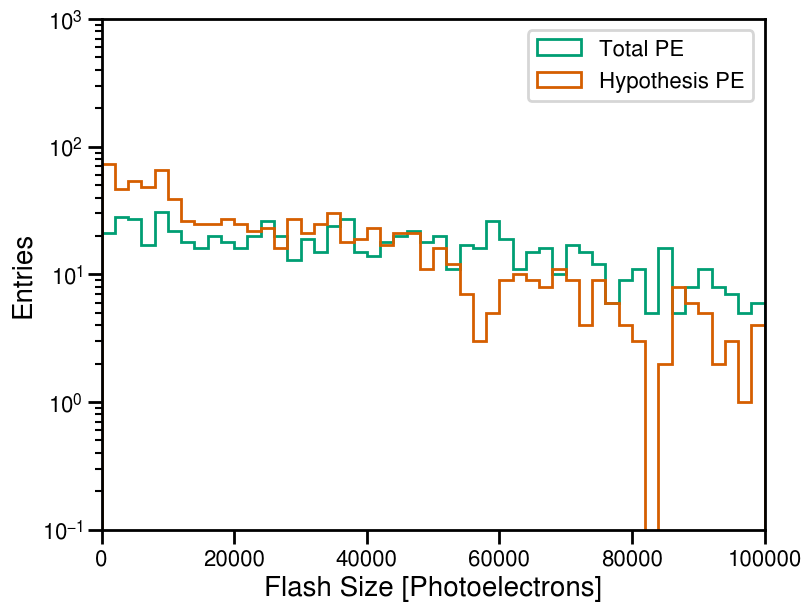

In [10]:
plot_flash_pe(interactions, mask_zero=True)

We can also look at a distribution of matched flash time and check that we get neutrinos in the beam window.

In [11]:
def plot_flash_time(interactions):
    """
    Plots the matched flash time of each interaction.
    
    Parameters
    ----------
    interactions: pandas.DataFrame
        The DataFrame containing the interaction-level information.
        
    Returns
    -------
    None.
    """
    figure = plt.figure(figsize=(8,6))
    ax = figure.add_subplot()
    plot_args = {'bins': 50, 'range': (-5, 5), 'histtype': 'step'}
    nu_mask = (interactions['true_nu_id'] == 1)
    ax.hist(interactions.loc[nu_mask]['reco_flash_time'], label='Neutrinos', **plot_args)
    ax.hist(interactions.loc[~nu_mask]['reco_flash_time'], label='Cosmics', **plot_args)
    ax.set_xlim(-5, 5)
    ax.set_xlabel('Matched Flash Time [$\mu$s]')
    ax.set_ylabel('Entries')
    ax.legend()

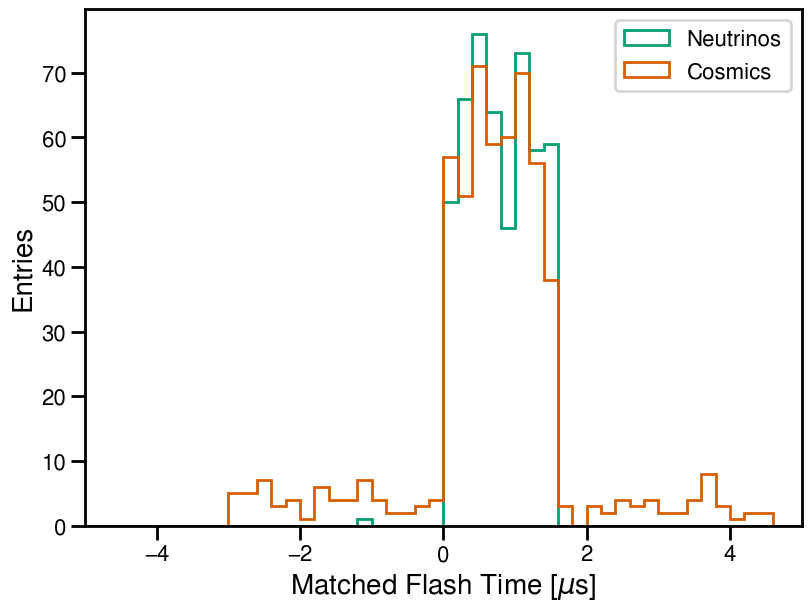

In [12]:
plot_flash_time(interactions)